<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/CP%20CPMG%20UDD%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [ ]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 44.3 MB/s eta 0:00:00


In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


#6. X Pulse Drive

###1) Qubit not coupled with Resonator (Rotating Frame)

$H = -\frac{\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

In [ ]:
# Basic parameters

omega_q = 2 * np.pi * 6.0  # resonator frequency in units of GHz
omega_rot = 2 * np.pi * 3.0  # qubit frequency in units of GHz

# kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz
#tau = 200 # readout pulse length in units of ns

tlist = np.linspace(0, 100, 1000)

In [ ]:
# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()

H0 = -0.5*omega_q*sz

op_list = [sx, sy, sz]

In [ ]:
# time-dependent coefficient for drive
def Hrd_env(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

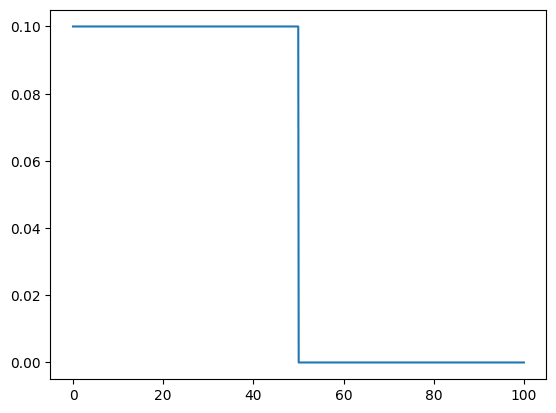

In [ ]:
# list of times for numerical simulation (in units of ns)
plt.figure()
plt.plot(tlist, Hrd_env(tlist, {'A': 0.1, 'T': 50, 'omega_rot': omega_rot}))

In [ ]:
result0 = mesolve(
    [sx, Hrd_env],
    basis(2,0),
    tlist,
    args = {'A': 0.1*np.pi, 'T': 5, 'omega_rot': omega_rot},
    e_ops = op_list,
    options = Options(nsteps = 1000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

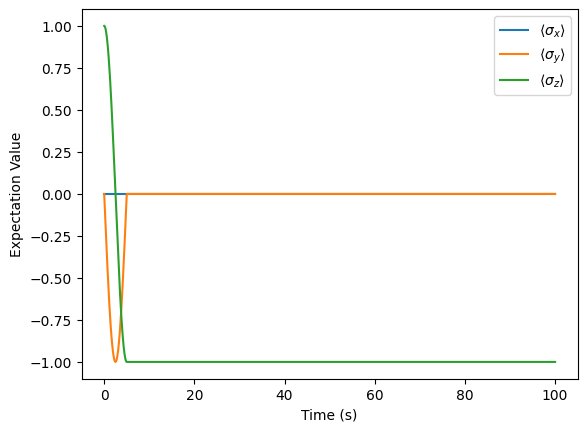

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result0.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result0.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result0.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

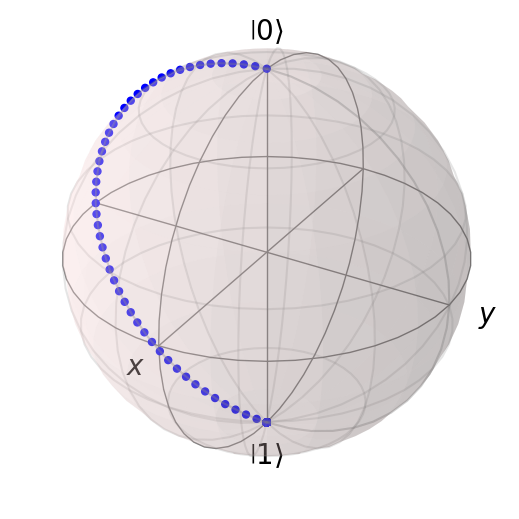

In [ ]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result0.expect, meth="s")
sphere.show()